In [3]:
import sys
import scanpy as sc 
import numpy as np

sys.path.append('/home/jupyter/data/PlastiNet_v2')

from plastinet.data.data_loader import create_data_objects
from plastinet.visualization.plots import plot_continous_obs, plot_tissue, plot_composition_dot_plot, plot_expression

In [4]:
adata = sc.read_h5ad("testing_data.h5ad") 

In [5]:
set(adata.obs["subset"])

{'epi', 'myeloids', 'plasmas', 'stroma', 'tcells'}

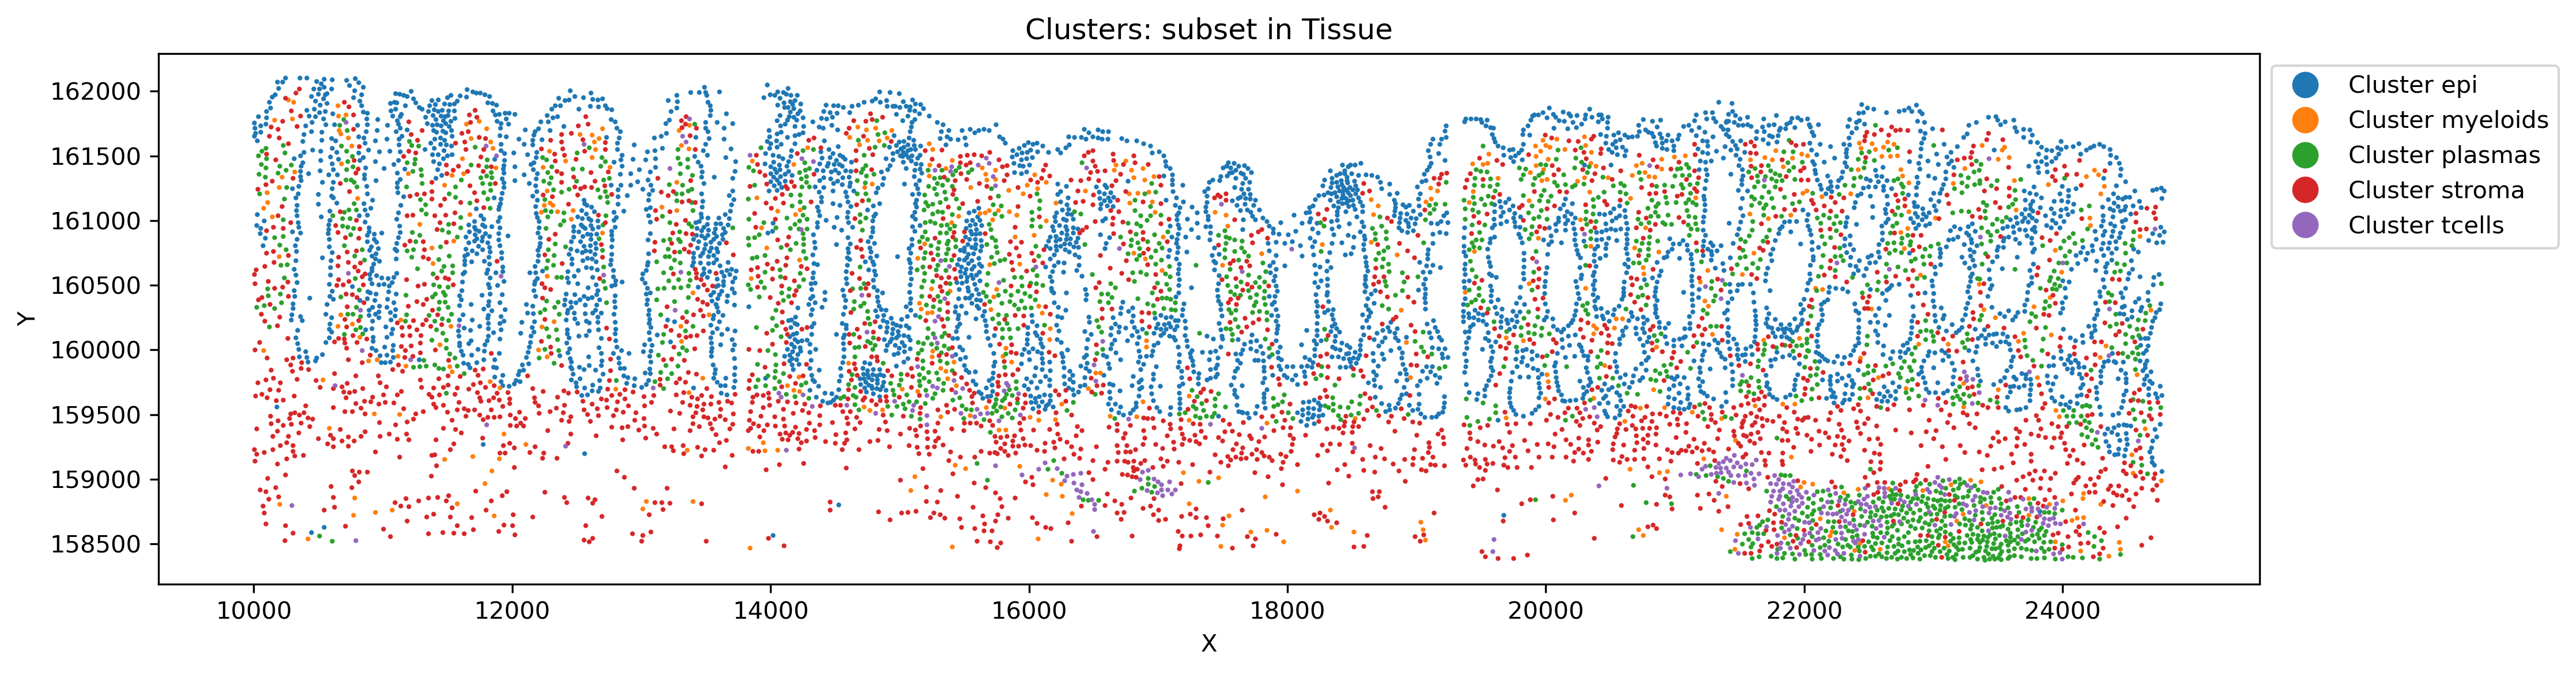

In [6]:
# plot spatialy by cell type 
plot_tissue(adata, "subset", figure_size=(15, 4))

In [7]:
# ensure spatial coordinates are in the correct place 
spatial_coords = np.array([adata.obs["X"], adata.obs["Y"]]).T
adata.obsm["spatial"] = spatial_coords

# Choose appropiate radius 

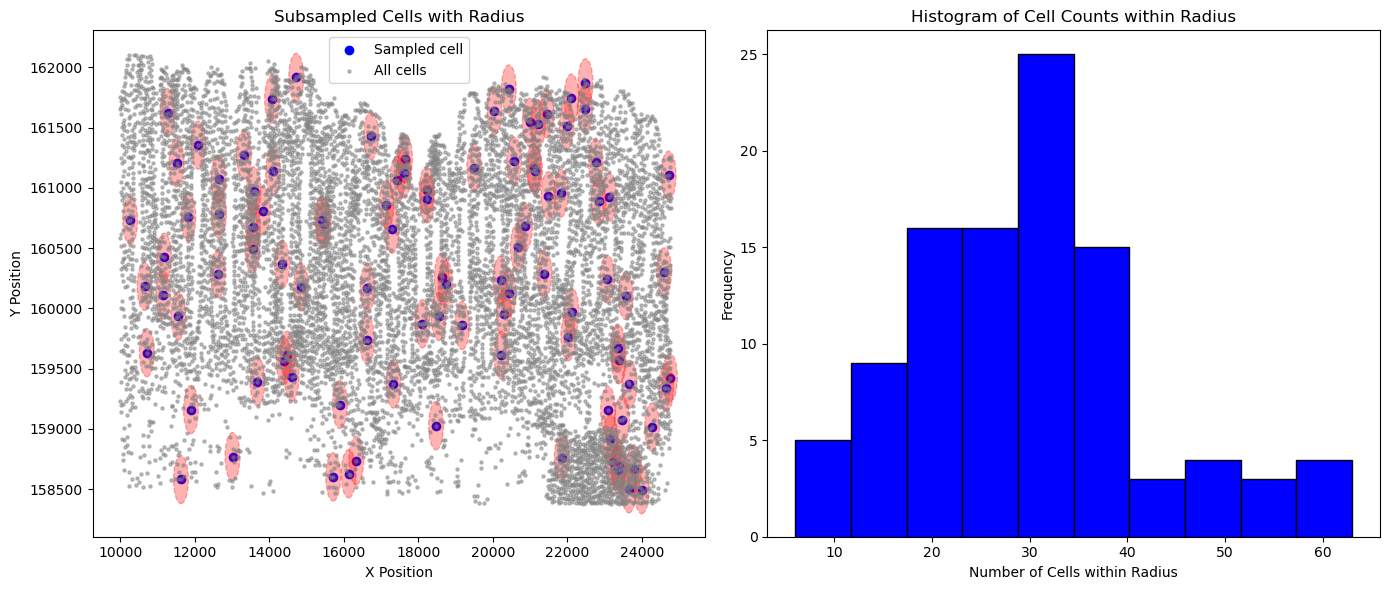

In [9]:
import plastinet.visualization.plots as plot
# select a radius that captures neighboring cells at desired resolution

plot.plot_subsample_radius(adata, x_samples = 100, radius = 200)

# Generate Embedding

Starting GAT run...
HC_b_
Model improved and parameters saved.
Epoch [1/15] Completed. Epoch Losses: DGI Loss = 1.3958, Spatial Loss = 0.3684, L1 Loss = 0.614298, Total Loss = 2.3784
Model improved and parameters saved.
Epoch [2/15] Completed. Epoch Losses: DGI Loss = 1.3679, Spatial Loss = 0.3711, L1 Loss = 0.586503, Total Loss = 2.3255
Model improved and parameters saved.
Epoch [3/15] Completed. Epoch Losses: DGI Loss = 1.3932, Spatial Loss = 0.3607, L1 Loss = 0.562400, Total Loss = 2.3164
Model improved and parameters saved.
Epoch [4/15] Completed. Epoch Losses: DGI Loss = 1.3506, Spatial Loss = 0.3603, L1 Loss = 0.539290, Total Loss = 2.2502
Model improved and parameters saved.
Epoch [5/15] Completed. Epoch Losses: DGI Loss = 1.3526, Spatial Loss = 0.3735, L1 Loss = 0.516541, Total Loss = 2.2426
Model improved and parameters saved.
Epoch [6/15] Completed. Epoch Losses: DGI Loss = 1.3225, Spatial Loss = 0.3737, L1 Loss = 0.494446, Total Loss = 2.1906
Model improved and parameters sa

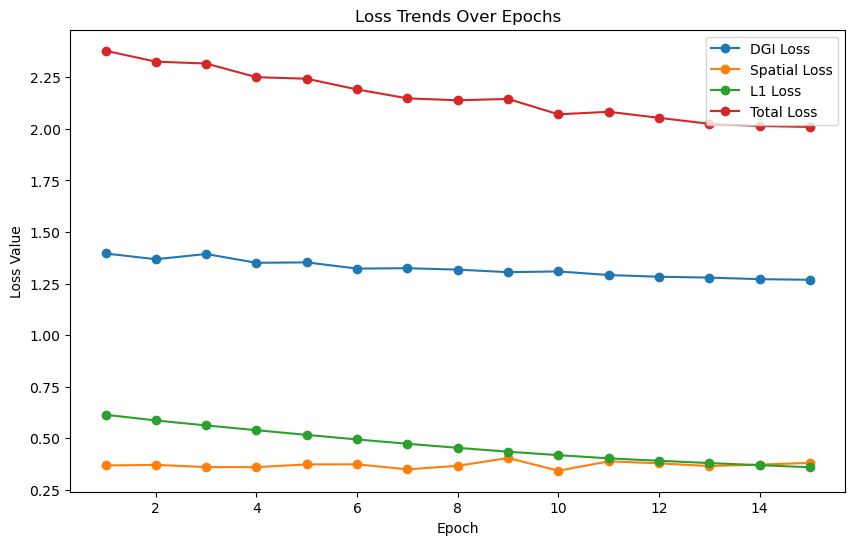

GAT run completed.


AnnData object with n_obs × n_vars = 9585 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y', 'final_avg_pseudotime', 'pseudotime_bins', 'leiden'
    uns: 'reduction_layers', 'neighbor_attention'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [92]:
import importlib
import torch
from torch_geometric.data import DataLoader

from plastinet.models import plastinet_model
from plastinet.data import data_loader, graph_utils
from plastinet.models.plastinet_model import PlastiNet
from plastinet.data.data_loader import create_data_objects
from plastinet.data.graph_utils import graph_alpha, sparse_mx_to_torch_edge_list, graph_to_sparse_matrix

importlib.reload(plastinet_model)

plastinet = PlastiNet(
    adata=adata, # adata object
    sample_key= 'sample_source', # tissue source ID
    radius=250, # radius to consider        
    spatial_reg=2, # weighting of spatial term in loss function   
    z_dim=50,  # output feature size of embedding            
    lr=0.001,  # learning rate      
    beta_1=0.9, # self weighting in layer 1
    beta_2=0.1, # self weighting in layer 2
    alpha=5.0, # weight for stregth of distance decay 
    attention_threshold = 0,
    weight_decay=1e-5,  
    dropout=0.3,
    gamma=0.8, # decay in lr for each step_size incriment 
    epochs=15,
    random_seed=42,               
    patience=10,         
    mask_n = 0.7, # DGI percent of features to mask 
    spatial_percent = 0.2, # percent of cells to sample to calculate spatial loss 
    step_size = 10
)

plastinet.run_gat()

In [93]:
embedding_adata = plastinet.embedding_adata
embedding_adata

AnnData object with n_obs × n_vars = 9585 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y', 'final_avg_pseudotime', 'pseudotime_bins', 'leiden'
    uns: 'reduction_layers', 'neighbor_attention'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [12]:
embedding_adata.write_h5ad("testing_delete_me.h5ad")

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


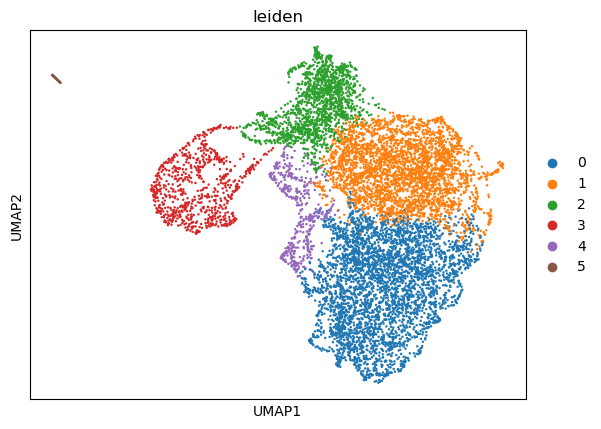

In [94]:
sc.pp.neighbors(embedding_adata, use_rep='X') 
sc.tl.umap(embedding_adata)
sc.tl.leiden(embedding_adata, resolution=0.15)
sc.pl.umap(embedding_adata, color = "leiden")

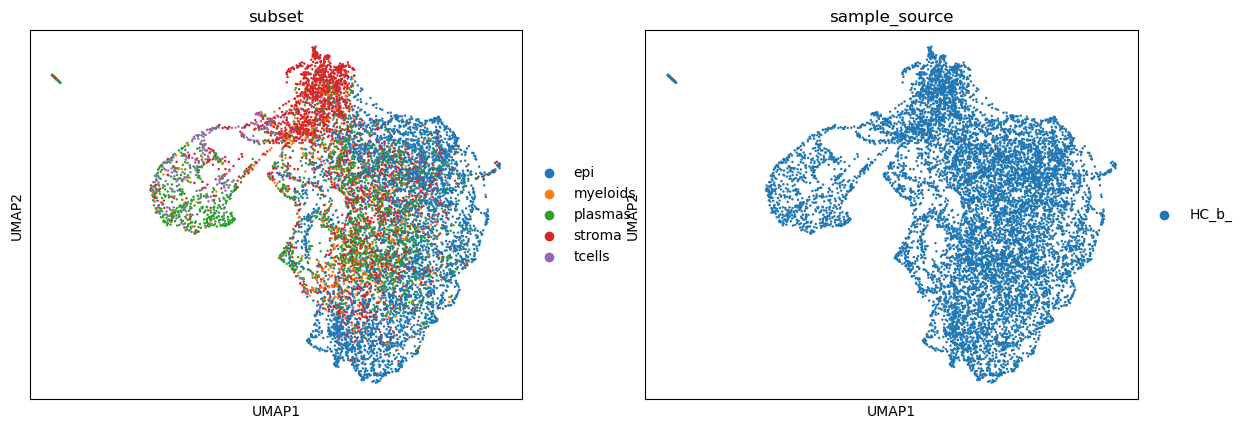

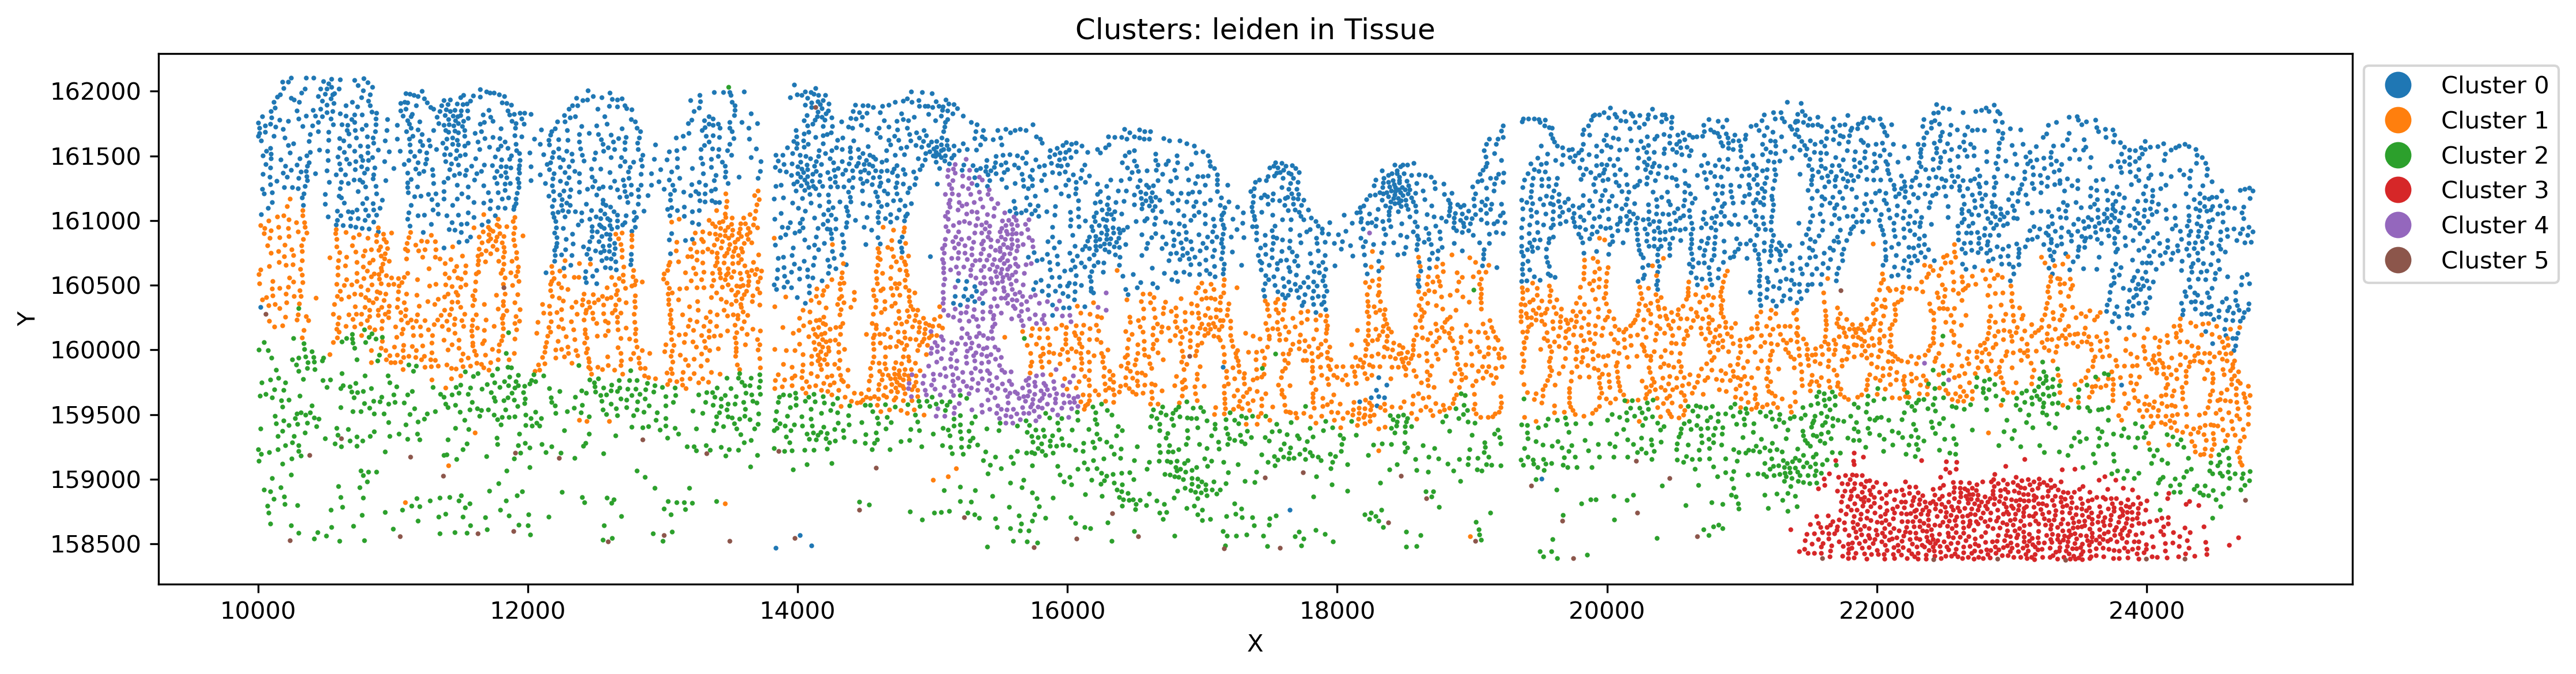

In [95]:
sc.pl.umap(embedding_adata, color = ["subset", "sample_source"])
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

# Pseudotime Construction

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/jupyter/data/PlastiNet_v2/plastinet/analysis/pseudotime.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gat_epi.obs['starting_score'] = exp_epi.obs['starting_score']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


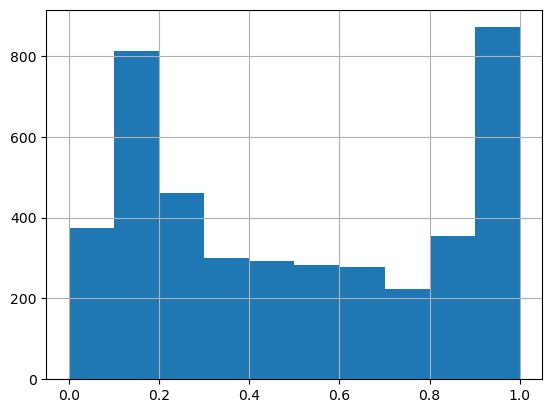

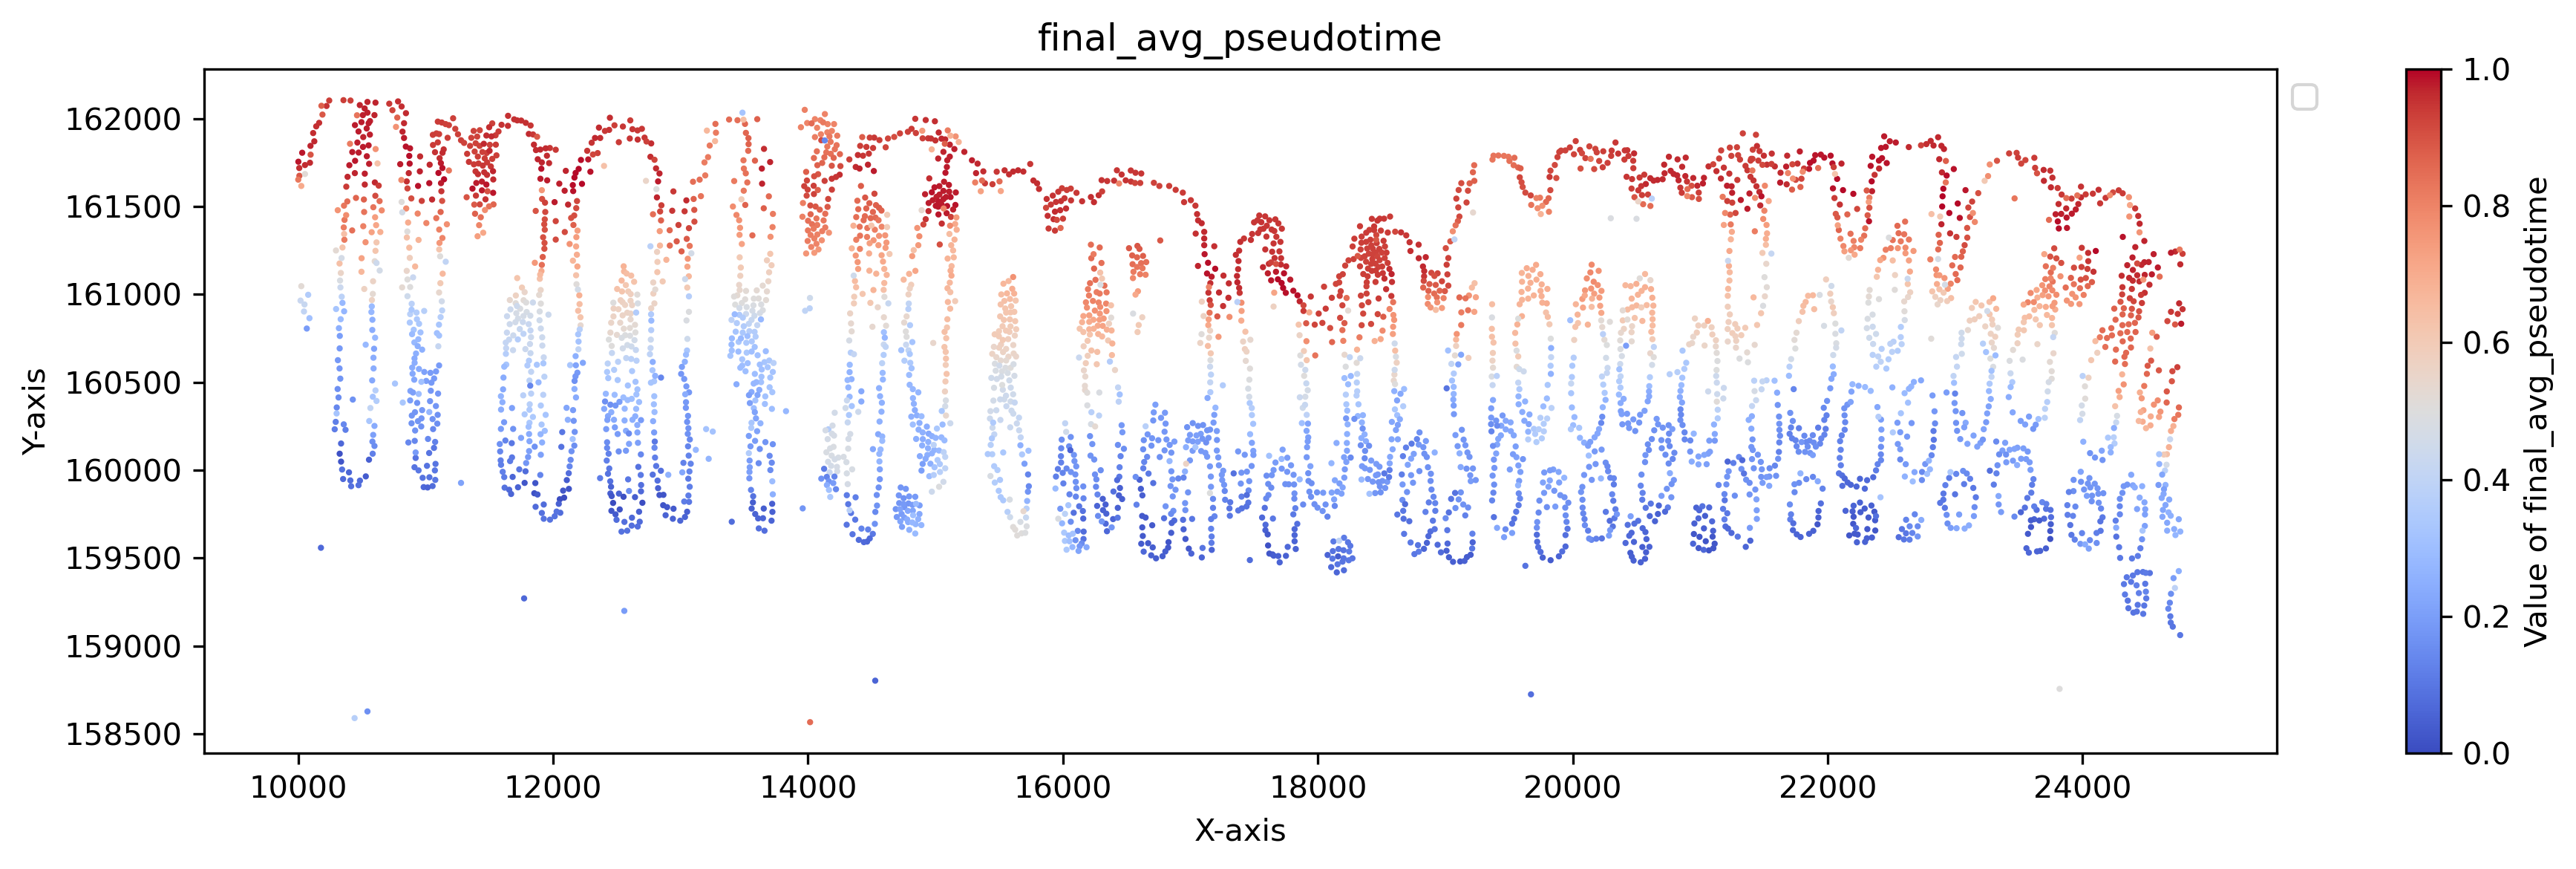

In [96]:
from plastinet.analysis import pseudotime
importlib.reload(pseudotime)

stem_cell_gene_list = ["CD44", "EPHB2", "EPHB3", "SOX9", 'ITGA1', 'ITGB1', 'ITGB2', 'ITGAX', 'ITGB4']
pseudotime.construct_differentiation_path(
    embedding_adata, 
    adata, 
    "subset", 
    "epi", 
    stem_cell_gene_list, # starting point gene list
    None,                # ending point gene list
    N=5                 # number of starting cells 
)

plot_continous_obs(embedding_adata, "final_avg_pseudotime", size = 1, figure_size=(15, 4))

In [97]:
adata.obs["final_avg_pseudotime"] = embedding_adata.obs["final_avg_pseudotime"]

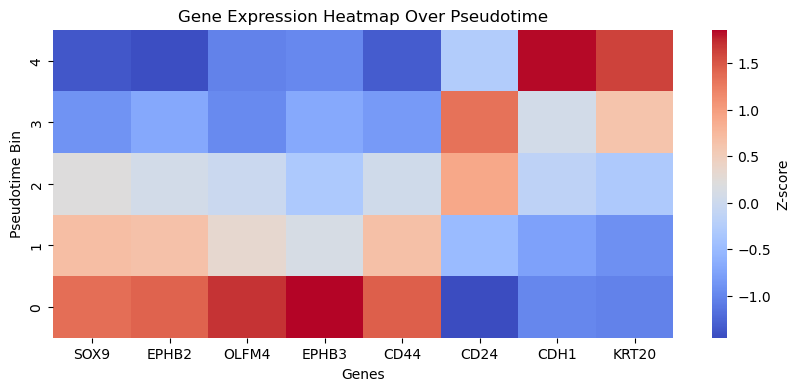

In [98]:
importlib.reload(pseudotime)

validation_genes = ["SOX9", "EPHB2","OLFM4", "EPHB3","CD44", "CD24", "CDH1", "KRT20"]

adata.obs["pseudotime_bins"] = pseudotime.plot_pseudotime_heatmap(adata, validation_genes, n_bins=5)

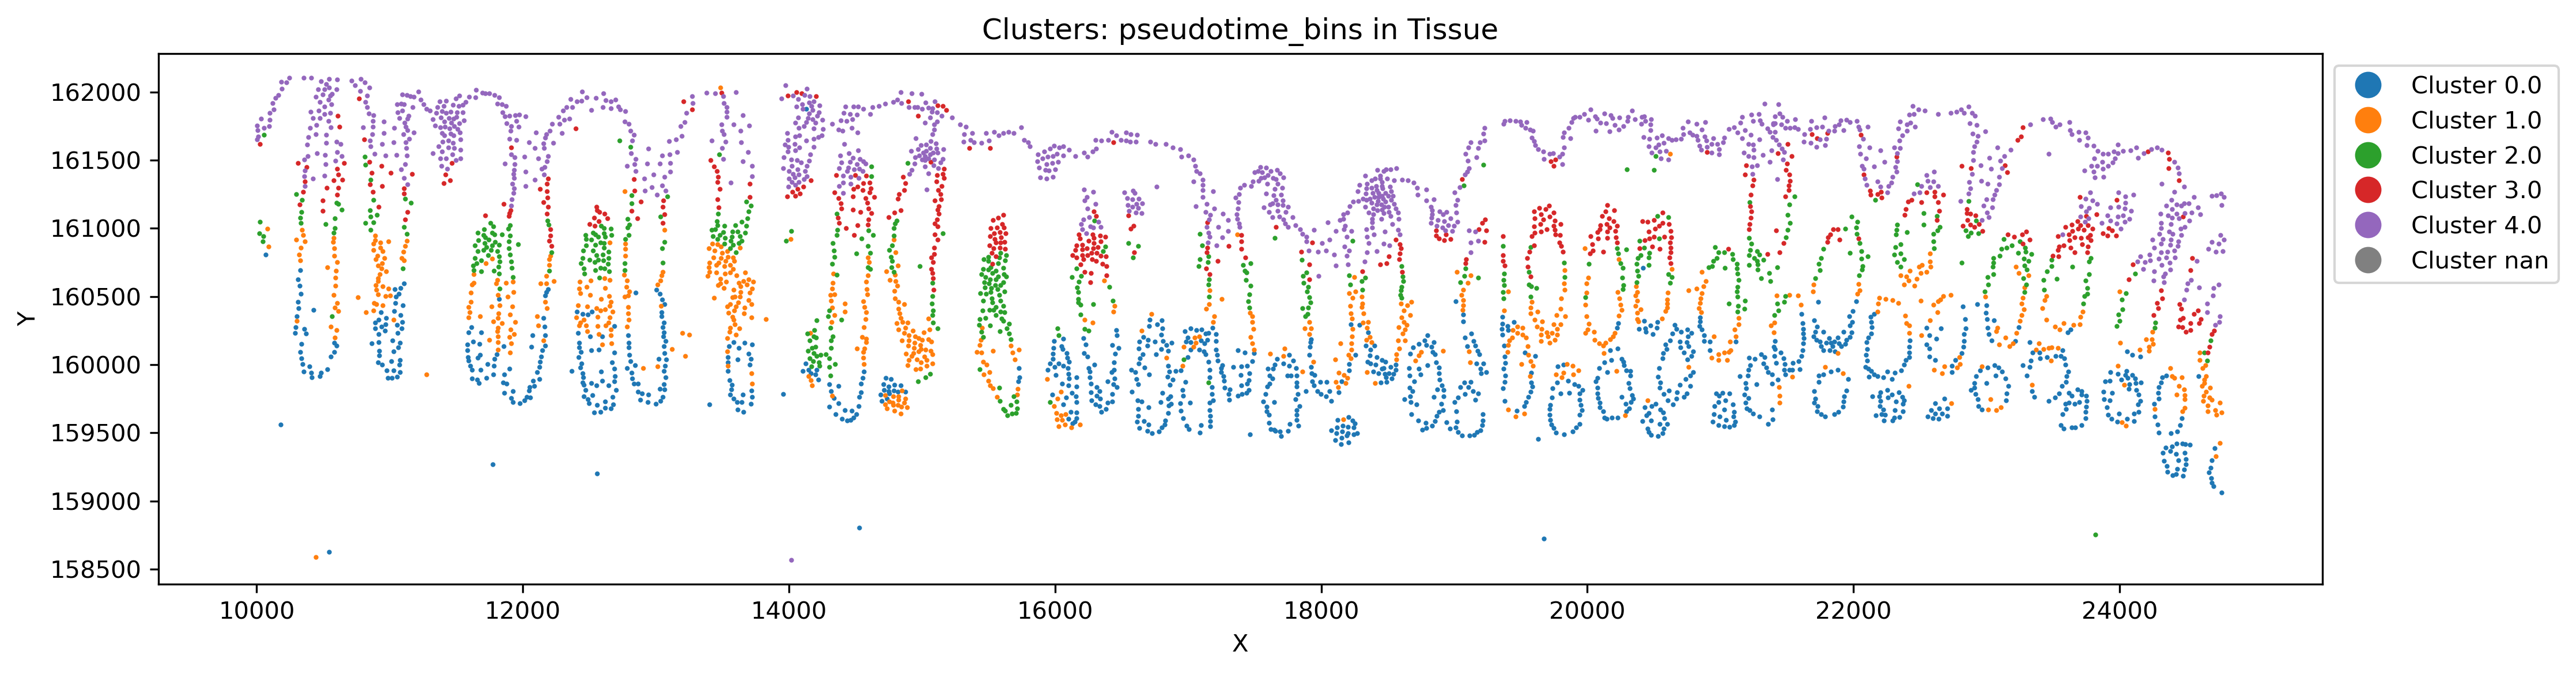

In [99]:
plot_tissue(adata, "pseudotime_bins", tabTen=True, figure_size=(15, 4))

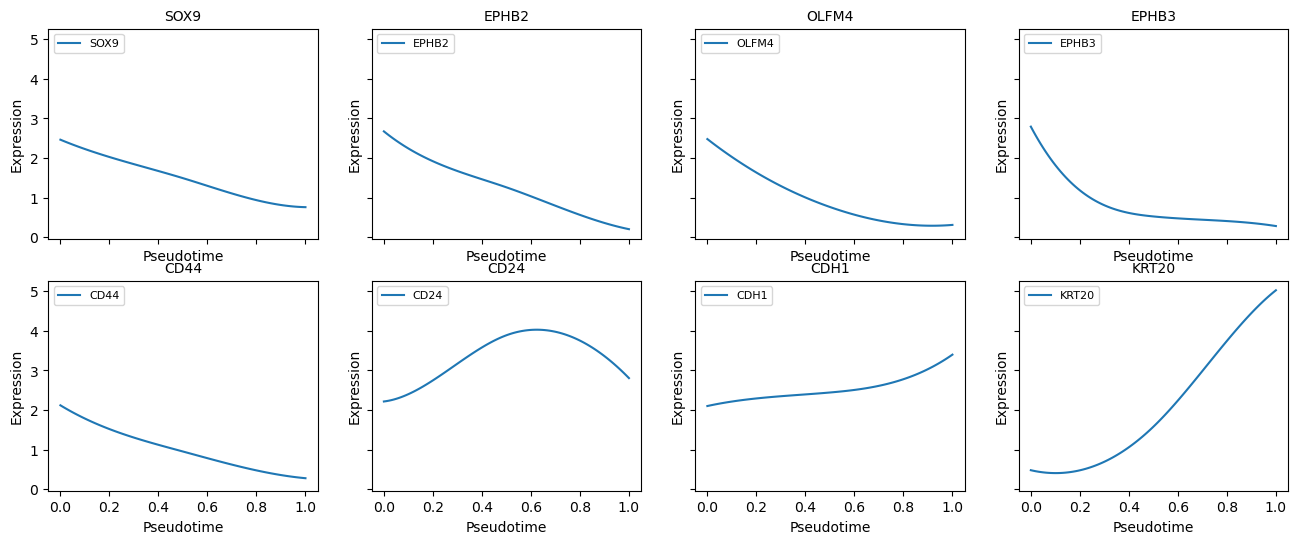

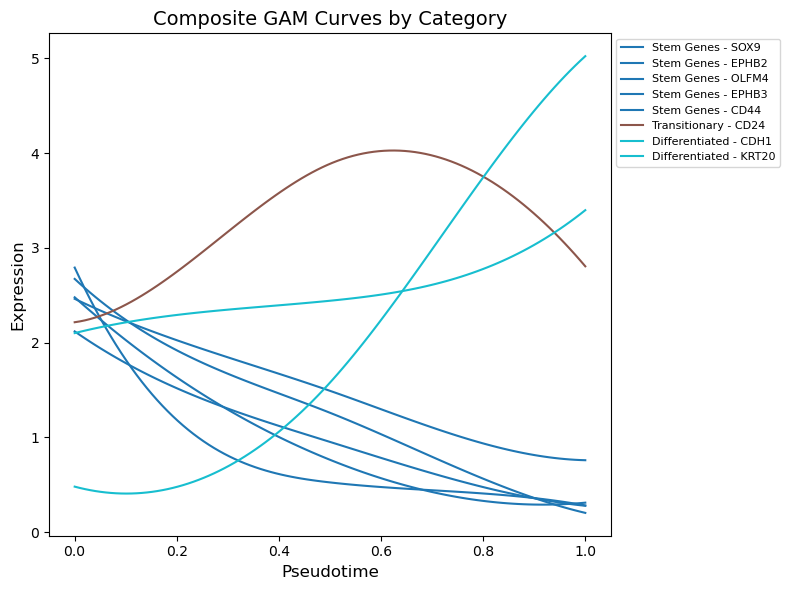

In [100]:
importlib.reload(pseudotime)


validation_genes = {"Stem Genes" : ["SOX9", "EPHB2","OLFM4", "EPHB3", "CD44"], 
                    "Transitionary":["CD24"], 
                    "Differentiated": ["CDH1", "KRT20"]} 


pseudotime.plot_gam_curves(adata, validation_genes)

# Neighborhood Analysis 

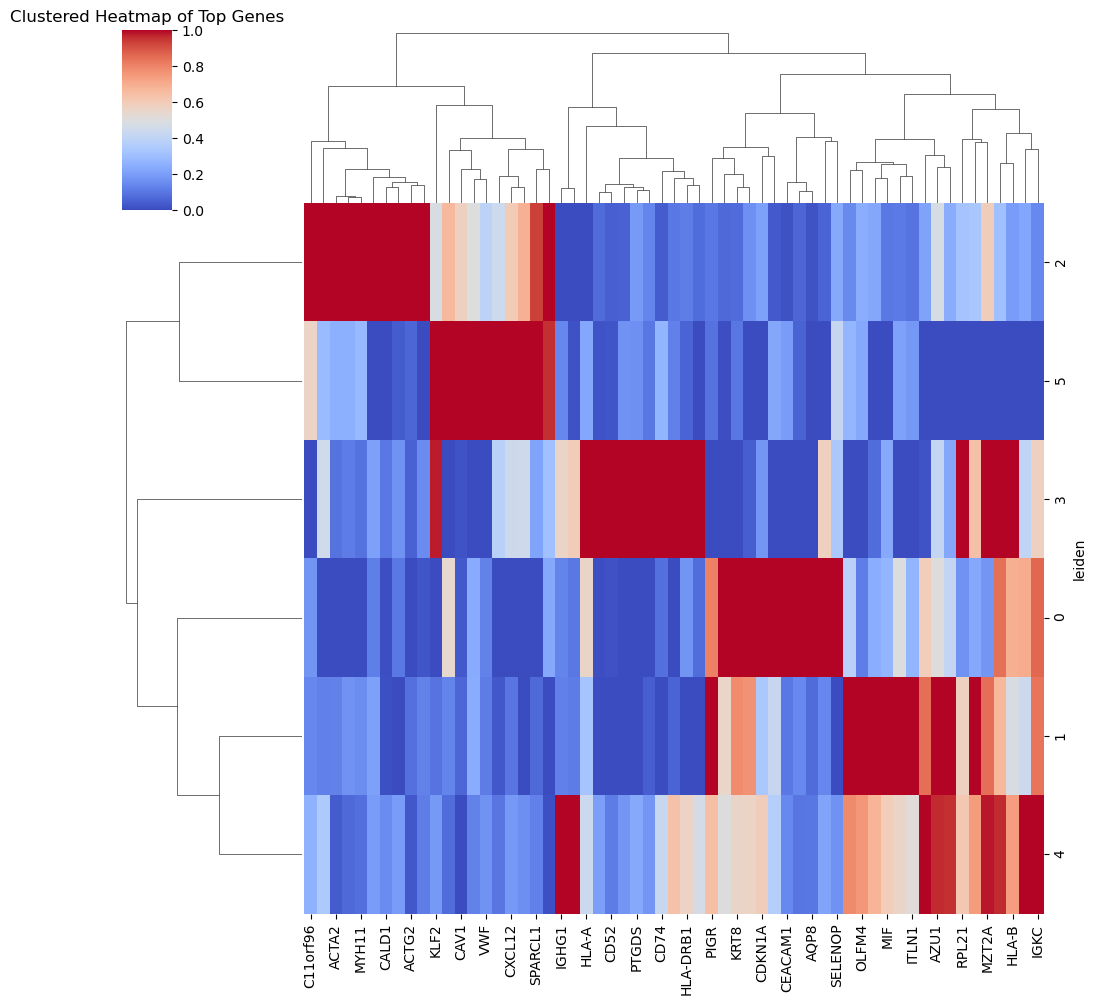

{'0': array(['KRT20', 'KRT19', 'AQP8', 'PLAC8', 'CEACAM1', 'KRT8', 'LGALS3',
        'SELENOP', 'KRT17', 'CDKN1A'], dtype=object),
 '1': array(['ITLN1', 'PIGR', 'AGR2', 'GSTP1', 'EPHB2', 'MIF', 'SOX9', 'AZU1',
        'HMGB2', 'OLFM4'], dtype=object),
 '2': array(['TAGLN', 'ACTA2', 'TPM2', 'MYH11', 'IGFBP5', 'ACTG2', 'MYL9',
        'CALD1', 'C11orf96', 'COL6A2'], dtype=object),
 '5': array(['CAV1', 'DCN', 'CXCL12', 'GSN', 'DUSP1', 'MGP', 'KLF2', 'SPARCL1',
        'GPX3', 'VWF'], dtype=object),
 '4': array(['IGHG1', 'IGHG2', 'CXCL14', 'MZT2A', 'CCL19', 'CD74', 'IGKC',
        'HLA-DRB1', 'DUSP5', 'HLA-C'], dtype=object),
 '3': array(['CD74', 'CXCR4', 'CCL21', 'CD37', 'HLA-A', 'PTGDS', 'HLA-DRA',
        'HLA-B', 'RPL21', 'CD52'], dtype=object)}

In [101]:
from plastinet.analysis import neighborhood_analysis
importlib.reload(neighborhood_analysis)

adata.obs["leiden"] = embedding_adata.obs["leiden"]

neighborhood_analysis.plot_top_genes_leiden(adata)

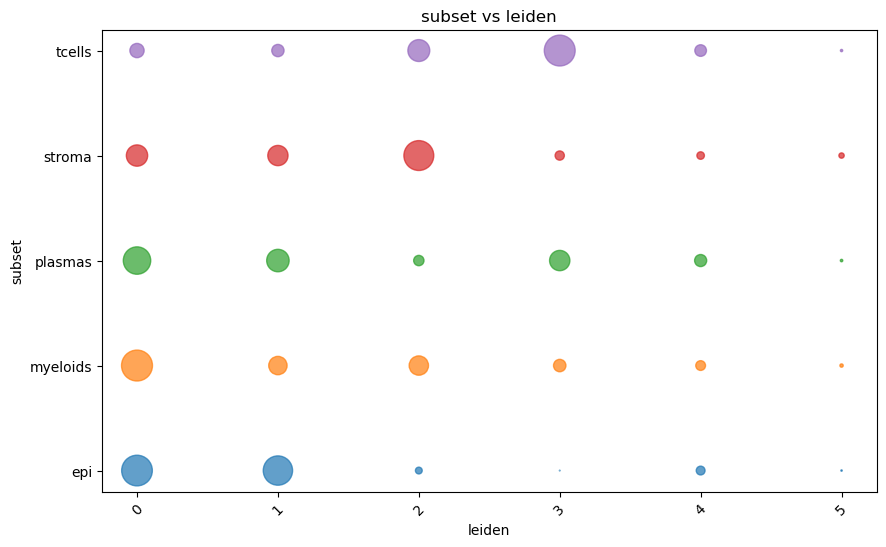

In [102]:
plot.plot_composition_dot_plot(adata, 'leiden', 'subset')

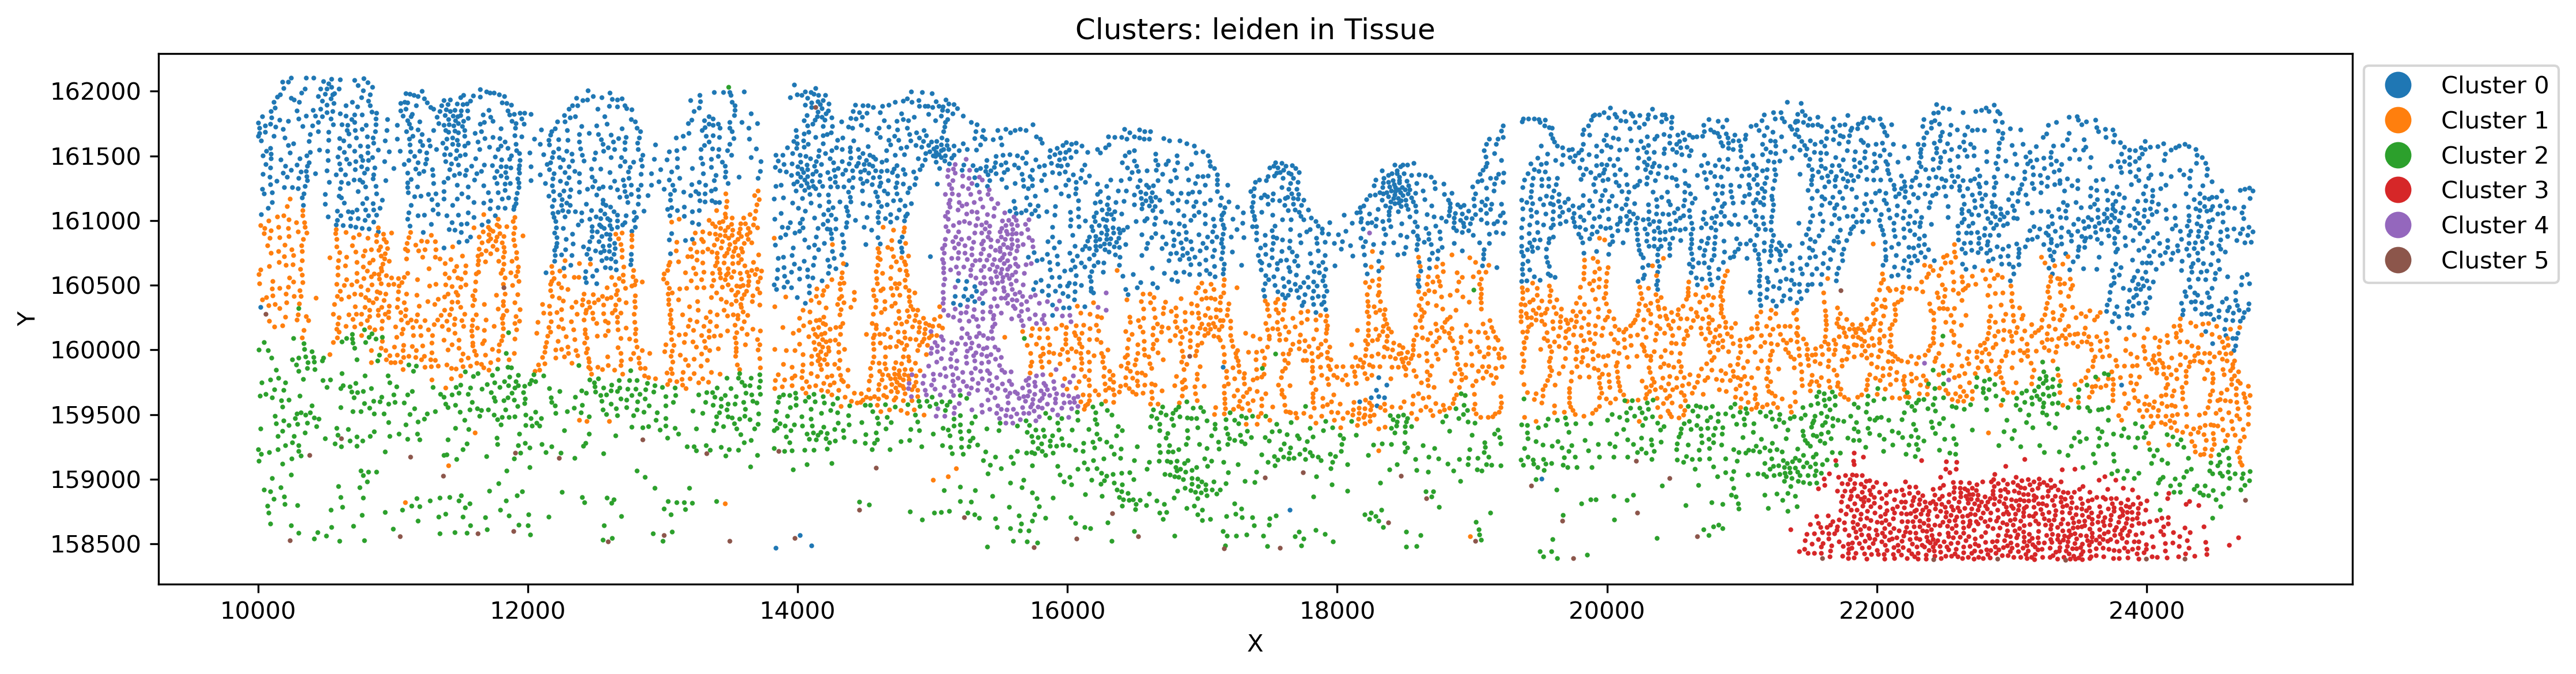

In [103]:
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

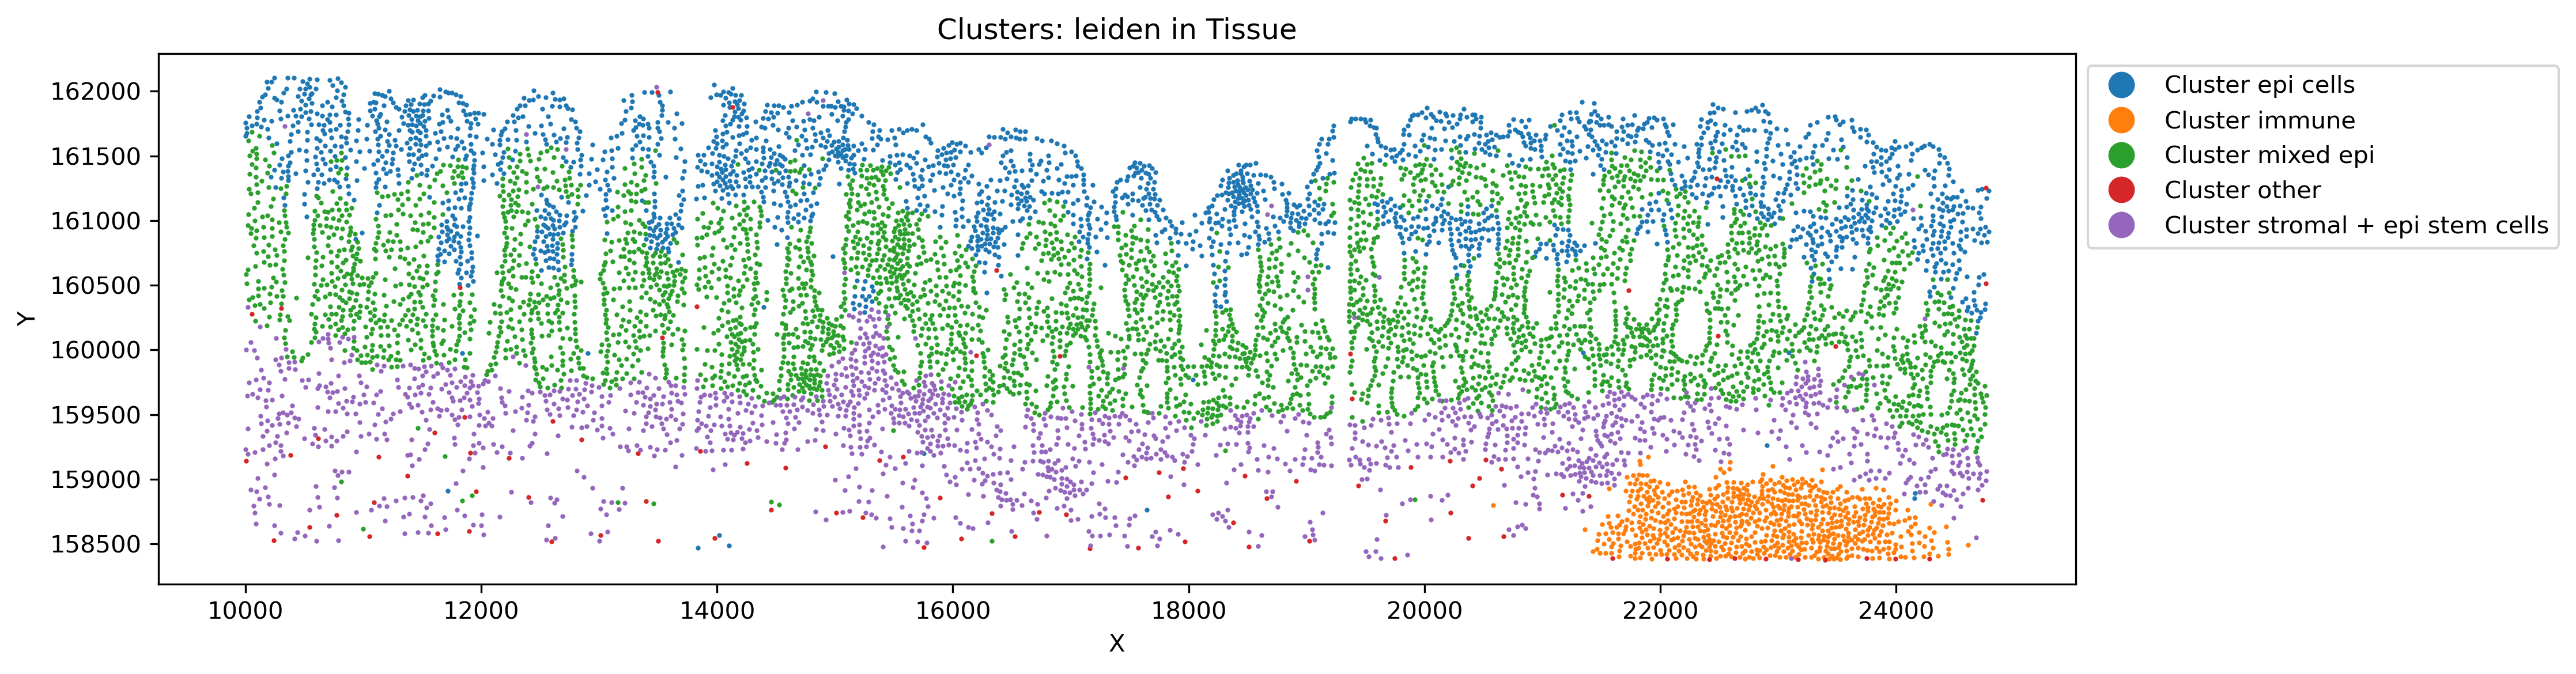

In [74]:
label_mapping = {
    "0": "mixed epi",
    "1": "epi cells",
    "2": "stromal + epi stem cells",
    "3": "immune",
    "4": "other",
}

embedding_adata.obs["leiden"] = embedding_adata.obs["leiden"].map(label_mapping)
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

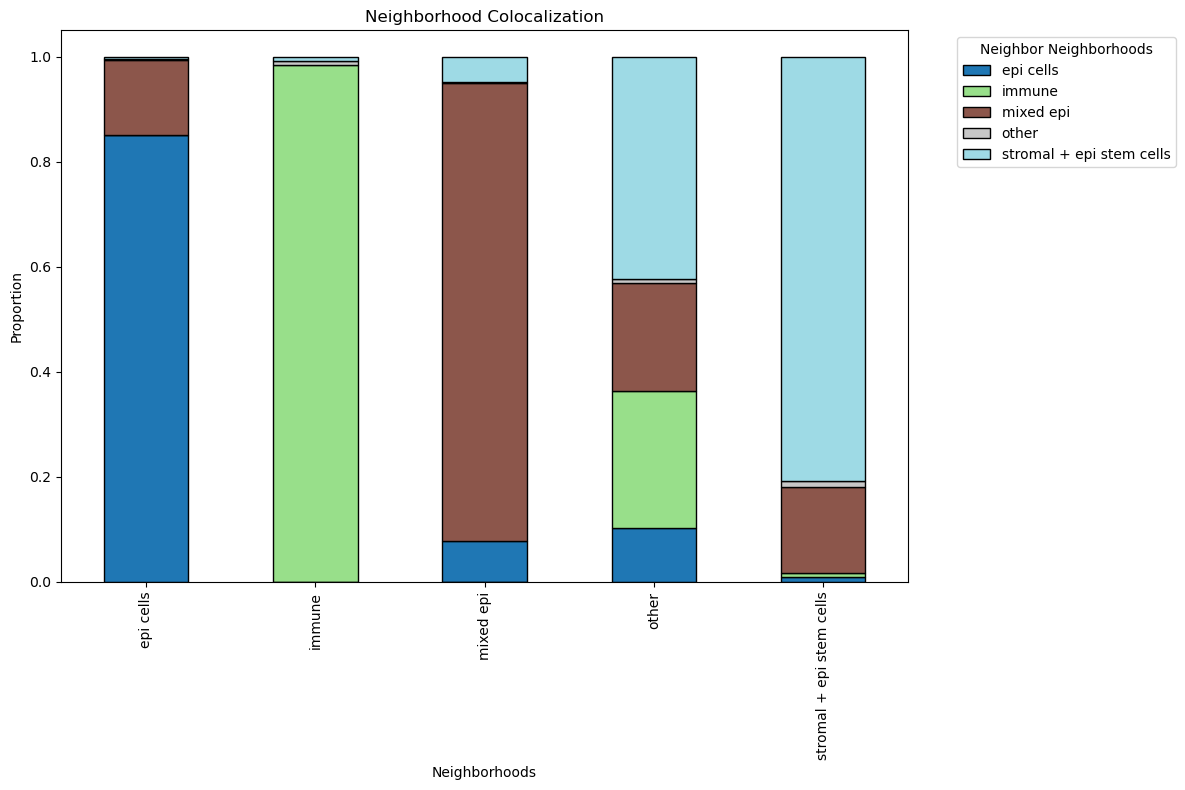

In [75]:
importlib.reload(neighborhood_analysis)

neighbor_colocalization = neighborhood_analysis.calculate_neighborhood_colocalization(embedding_adata)

neighborhood_analysis.plot_neighborhood_colocalization(neighbor_colocalization)

# Spatial Co Localization

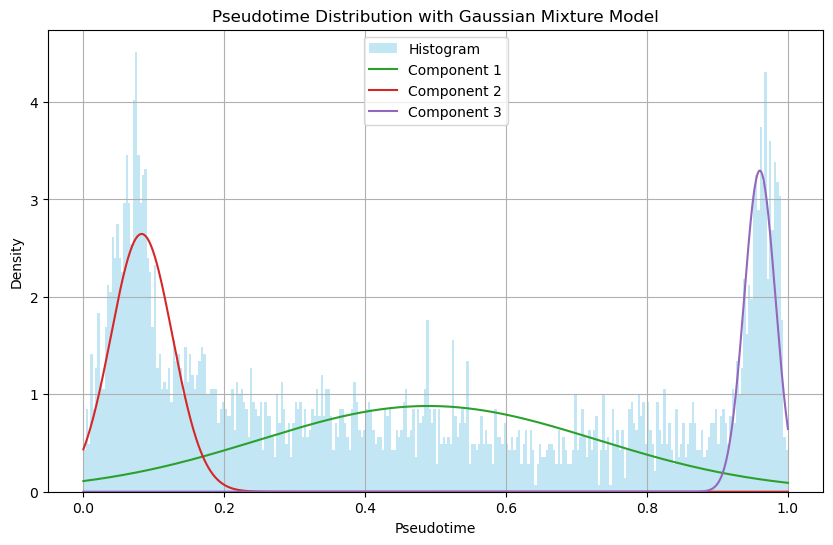

In [76]:

from plastinet.analysis import spatial_colocalization
importlib.reload(spatial_colocalization)

spatial_colocalization.gmm_discretize_pseudotime(embedding_adata, 
                                                 "final_avg_pseudotime", 
                                                 n_components=3, 
                                                 output_label_key="GMM_labels", 
                                                 plot=True)

In [77]:
label_mapping = {
    1.0: "Transitionary",
    3.0: "Differentiated",
    2.0: "Stem"
}

embedding_adata.obs["GMM_labels"] = embedding_adata.obs["GMM_labels"].map(label_mapping)

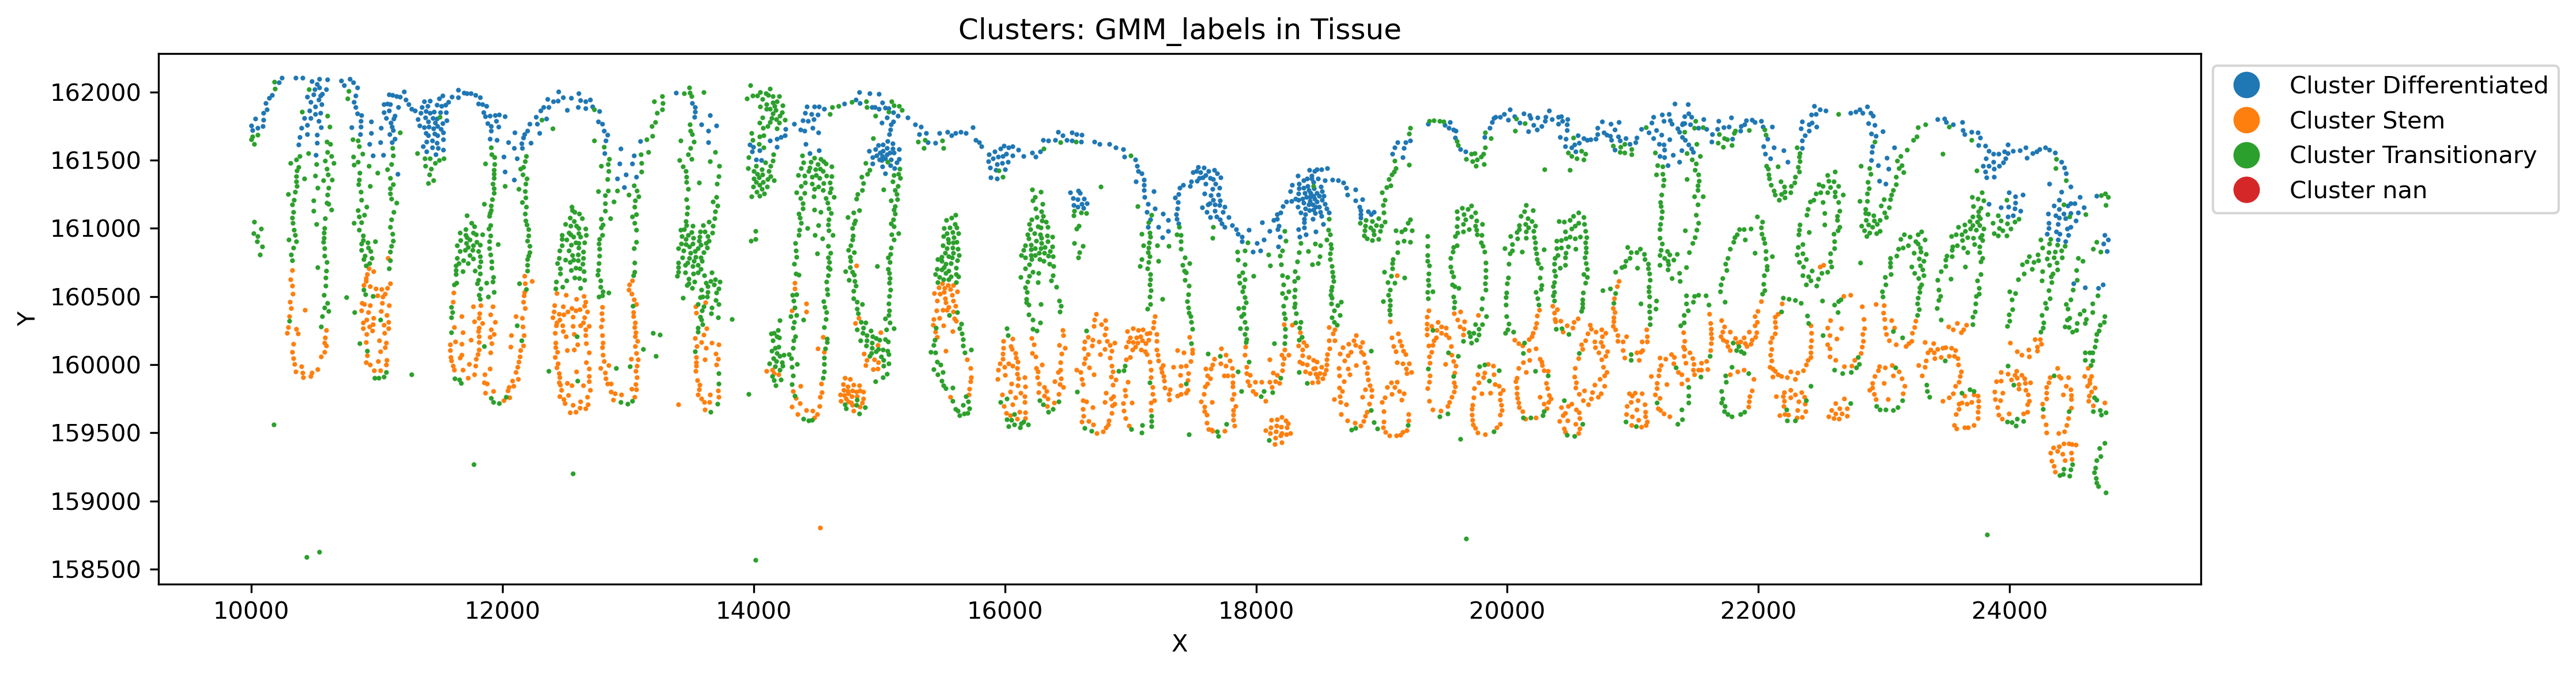

In [78]:

plot_tissue(embedding_adata, "GMM_labels", figure_size=(15, 4))

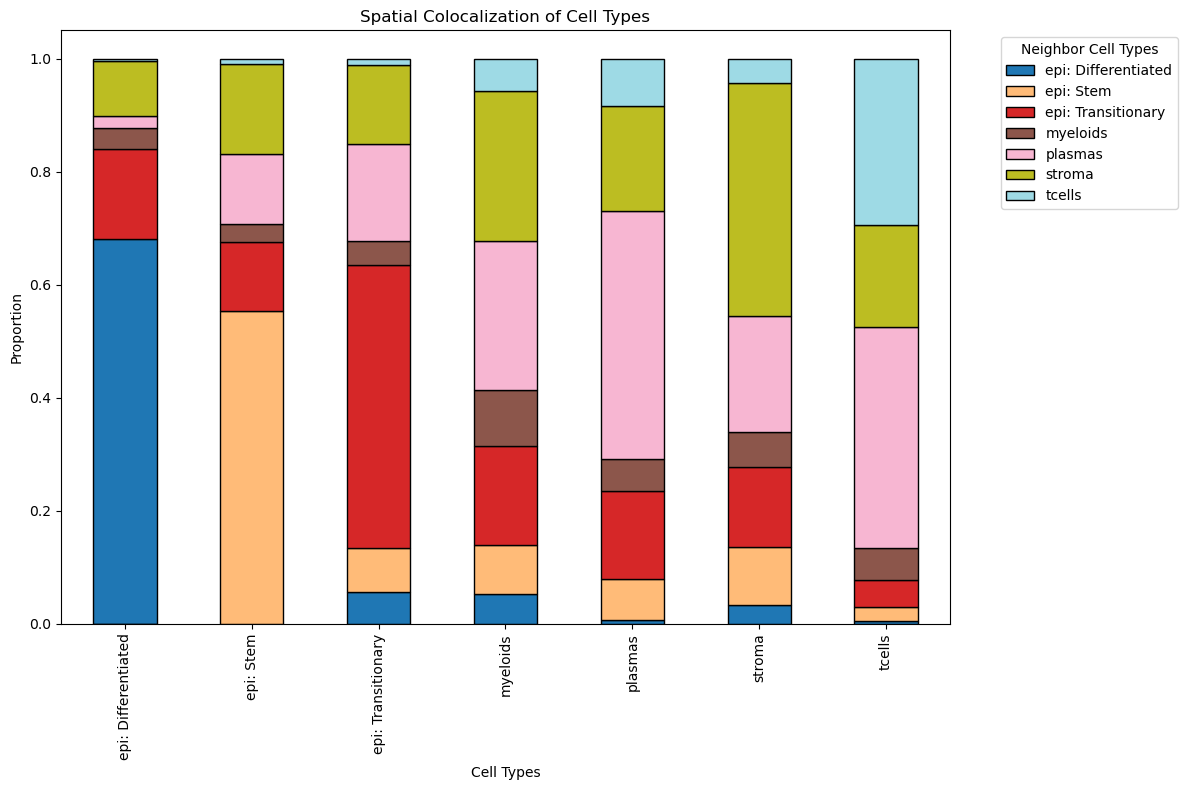

In [79]:

importlib.reload(spatial_colocalization)

output = spatial_colocalization.calculate_colocalization(embedding_adata, 
                                                x_key="X", 
                                                y_key="Y", 
                                                cell_type_key="subset", 
                                                subtype_key="GMM_labels", 
                                                radius=200)

spatial_colocalization.plot_stacked_colocalization(output, normalize=True)

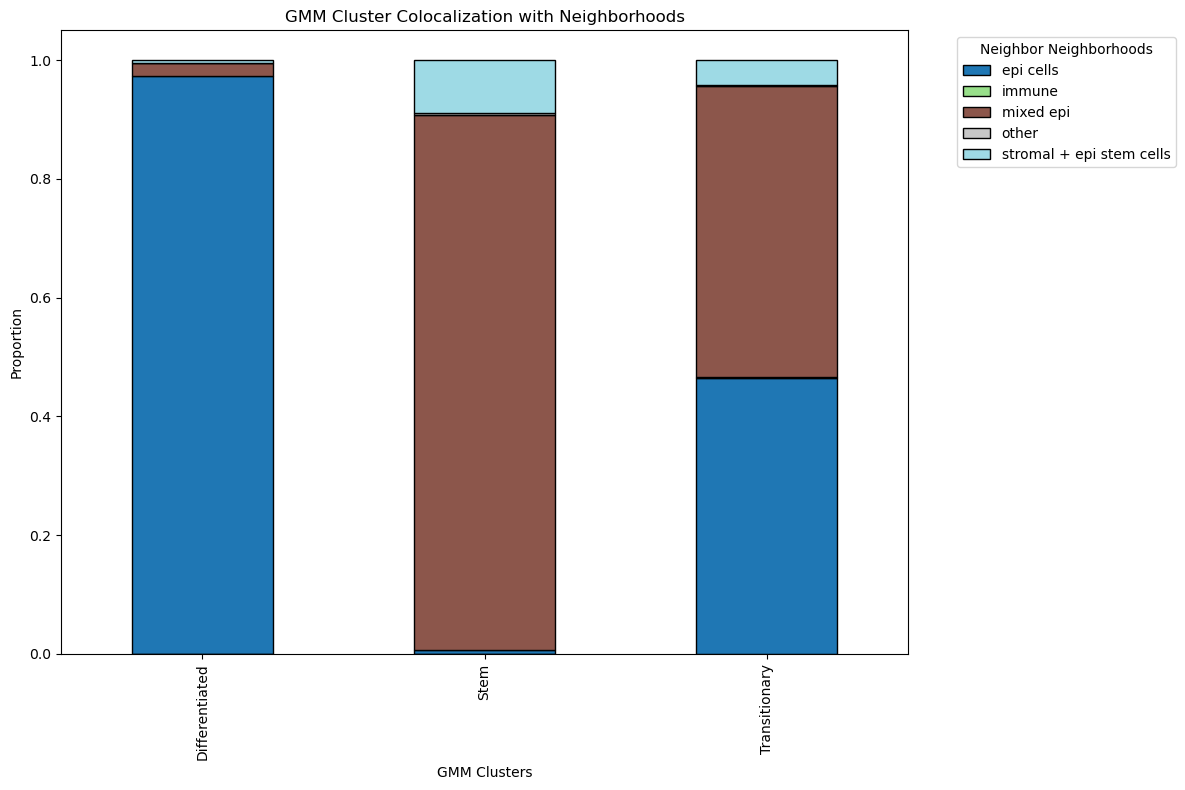

In [80]:

importlib.reload(spatial_colocalization)
gmm_colocalization = spatial_colocalization.calculate_gmm_colocalization(
    adata=embedding_adata,
    x_key="X",
    y_key="Y",
    leiden_key="leiden",
    gmm_key="GMM_labels",
    radius=200
)
spatial_colocalization.plot_gmm_colocalization(gmm_colocalization)


In [81]:
importlib.reload(spatial_colocalization)

# Calculate Morgan's I 
# I>0: Positive spatial autocorrelation (similar values are spatially clustered)
# I=0: No spatial autocorrelation (random spatial distribution)
# I<0: Negative spatial autocorrelation (dissimilar values are spatially clustered)

spatial_colocalization.compute_spatial_autocorrelation(embedding_adata,
                                x_key="X",
                                y_key="Y",
                                gmm_key="GMM_labels")

Differentiated    0.164805
Transitionary     0.104411
Stem              0.172177
dtype: float64

# Attention Analysis

Found 51 invalid rows in attention_weights. Removing them.


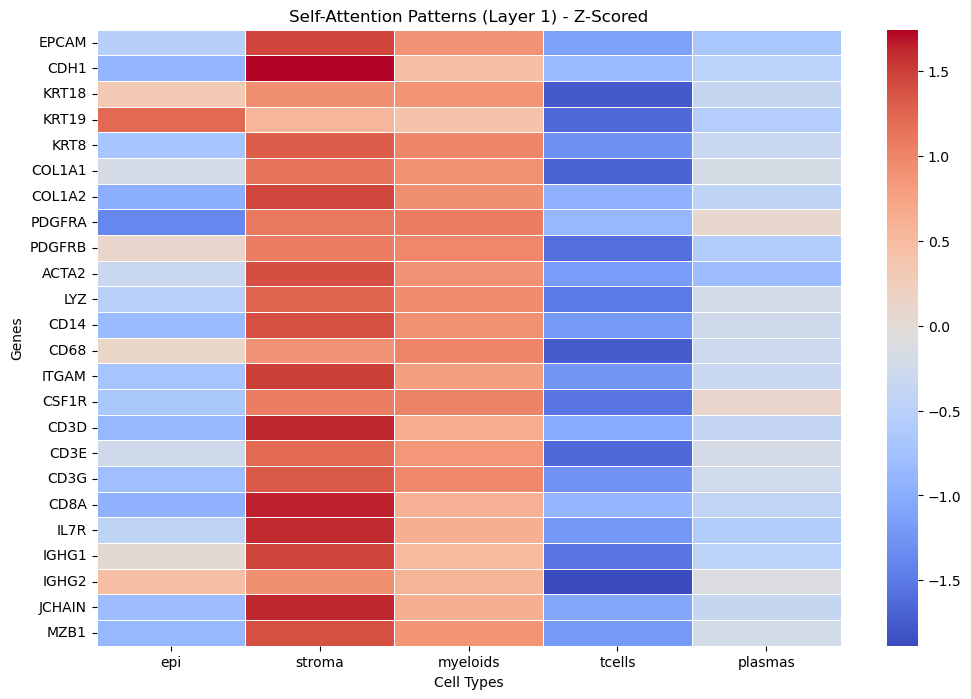

Found 51 invalid rows in attention_weights. Removing them.


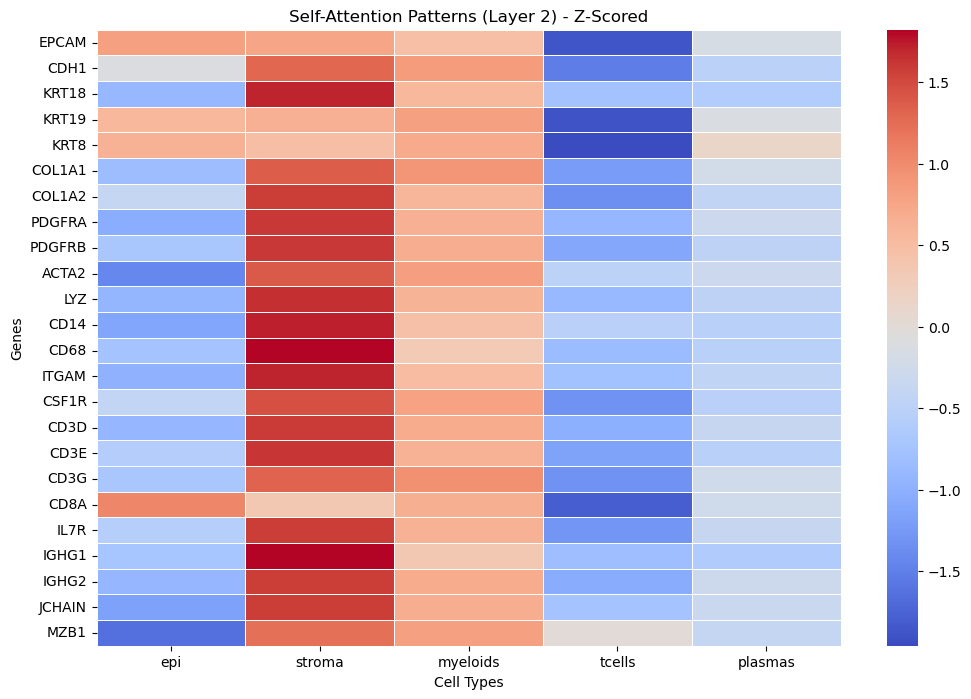

In [105]:
from plastinet.analysis import attention_analysis
importlib.reload(attention_analysis)


marker_genes = ["EPCAM", "CDH1", "KRT18", "KRT19", "KRT8",
               "COL1A1", "COL1A2", "PDGFRA", "PDGFRB", "ACTA2",
                "LYZ", "CD14", "CD68", "ITGAM", "CSF1R",
                "CD3D", "CD3E", "CD3G", "CD8A", "IL7R", 
                "IGHG1", "IGHG2", "JCHAIN", "MZB1"]

attention_analysis.analyze_self_attention_layer(embedding_adata, adata, gene_list = marker_genes, normalize=True, layer = "1")
attention_analysis.analyze_self_attention_layer(embedding_adata, adata, gene_list = marker_genes, normalize=True, layer = "2")

Found 51 invalid rows. Removing them.


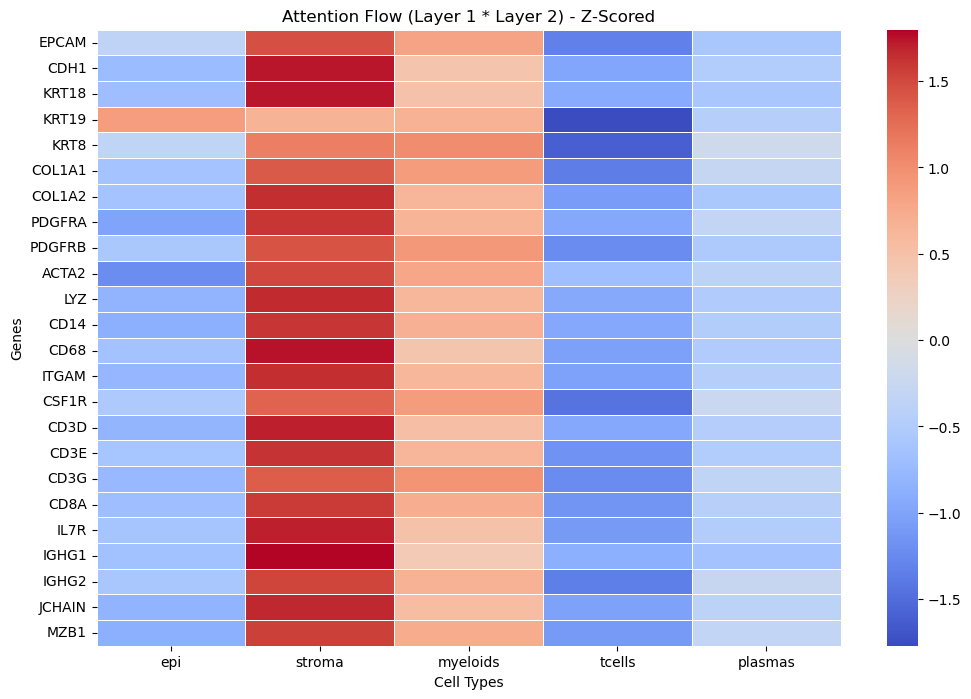

epi    stroma  myeloids    tcells   plasmas
EPCAM  -0.349320  1.455040  0.808954 -1.327093 -0.587580
CDH1   -0.732276  1.741929  0.468255 -0.981941 -0.495967
KRT18  -0.708247  1.738564  0.499189 -0.933416 -0.596091
KRT19   0.871415  0.667511  0.678886 -1.770281 -0.447530
KRT8   -0.341655  1.116010  1.011925 -1.606723 -0.179557
COL1A1 -0.629564  1.383447  0.882535 -1.352962 -0.283456
COL1A2 -0.630916  1.648647  0.629252 -1.080079 -0.566904
PDGFRA -0.995271  1.609288  0.646428 -0.952246 -0.308200
PDGFRB -0.558862  1.425930  0.911504 -1.237065 -0.541507
ACTA2  -1.214280  1.510596  0.783904 -0.691237 -0.388984
LYZ    -0.832882  1.665118  0.619381 -0.945424 -0.506193
CD14   -0.865341  1.614644  0.696519 -0.961415 -0.484407
CD68   -0.654150  1.745546  0.447565 -1.034662 -0.504299
ITGAM  -0.791947  1.653679  0.614868 -1.029788 -0.446811
CSF1R  -0.531861  1.336417  0.885552 -1.444502 -0.245607
CD3D   -0.814873  1.705308  0.538178 -0.957004 -0.471608
CD3E   -0.608119  1.626340  0.632839 -1.158489 -0.492571
CD3G   -0.756808  1.374976  0.952784 -1.229852 -0.341100
CD8A   -0.700894  1.576218  0.711432 -1.153414 -0.433341
IL7R   -0.622985  1.709914  0.497955 -1.095916 -0.488968
IGHG1  -0.658674  1.798068  0.384298 -0.872740 -0.650952
IGHG2  -0.580427  1.528884  0.669869 -1.341801 -0.276525
JCHAIN -0.830525  1.681172  0.547662 -1.020342 -0.377966
MZB1   -0.876369  1.553840  0.726370 -1.092151 -0.311690

In [106]:
importlib.reload(attention_analysis)

attention_analysis.analyze_attention_flow(
    embedding_adata, 
    adata, 
    cell_type_col='subset', 
    gene_list=marker_genes,
    normalize=True, 
)

Found 96 invalid rows. Removing them.


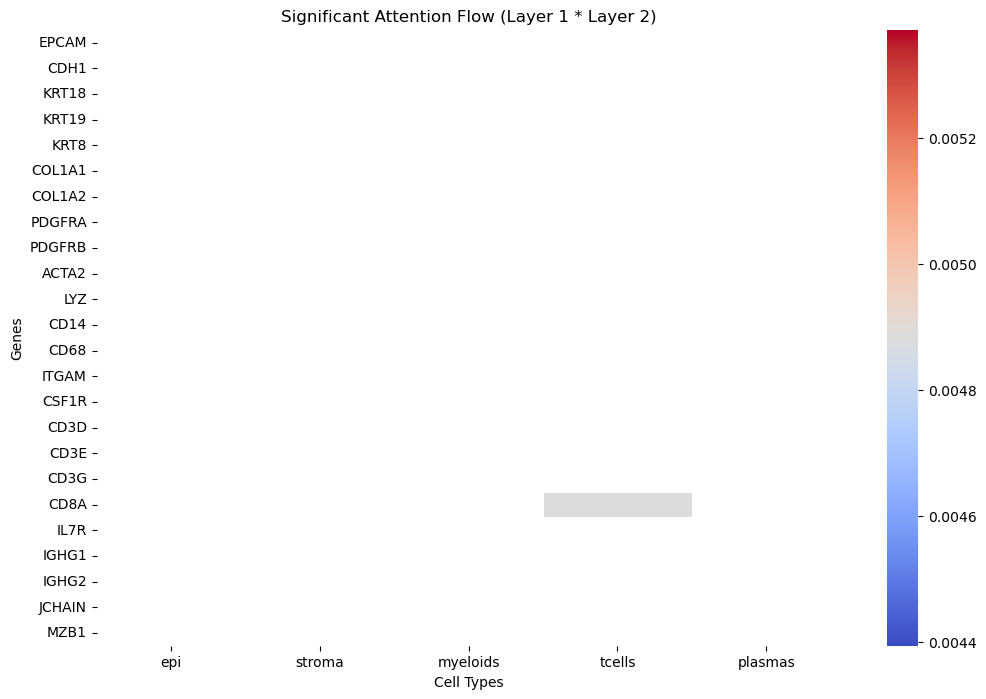

epi  stroma  myeloids  tcells  plasmas
EPCAM   0.996   0.457     0.783   0.986    0.950
CDH1    1.000   0.984     0.917   1.000    0.408
KRT18   0.954   1.000     0.713   0.833    0.619
KRT19   1.000   0.852     1.000   0.072    0.237
KRT8    0.999   0.883     0.872   0.997    1.000
COL1A1  0.769   1.000     0.927   0.879    0.999
COL1A2  0.679   0.990     0.773   0.999    0.926
PDGFRA  0.689   0.581     0.916   0.968    0.728
PDGFRB  0.747   1.000     0.674   0.442    0.995
ACTA2   1.000   0.984     0.995   1.000    0.968
LYZ     0.996   0.512     1.000   0.927    0.799
CD14    1.000   0.967     0.911   0.984    0.998
CD68    1.000   0.998     0.289   0.852    0.717
ITGAM   0.891   0.995     0.317   0.877    0.817
CSF1R   1.000   1.000     0.997   0.964    0.333
CD3D    0.639   0.985     0.759   0.305    0.903
CD3E    0.288   0.349     0.827   0.642    0.750
CD3G    0.505   1.000     1.000   0.163    0.831
CD8A    0.995   0.967     0.616   0.020    0.751
IL7R    0.480   1.000     0.998   1.000    1.000
IGHG1   1.000   1.000     1.000   0.997    0.975
IGHG2   0.724   0.080     1.000   0.583    0.936
JCHAIN  0.467   0.971     0.358   0.855    0.848
MZB1    1.000   1.000     0.972   0.855    0.914

In [90]:
# attemtping to include sig 

importlib.reload(attention_analysis)

attention_analysis.analyze_attention_flow_with_permutation(
    embedding_adata, adata, cell_type_col='subset', 
    gene_list=marker_genes,
)

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


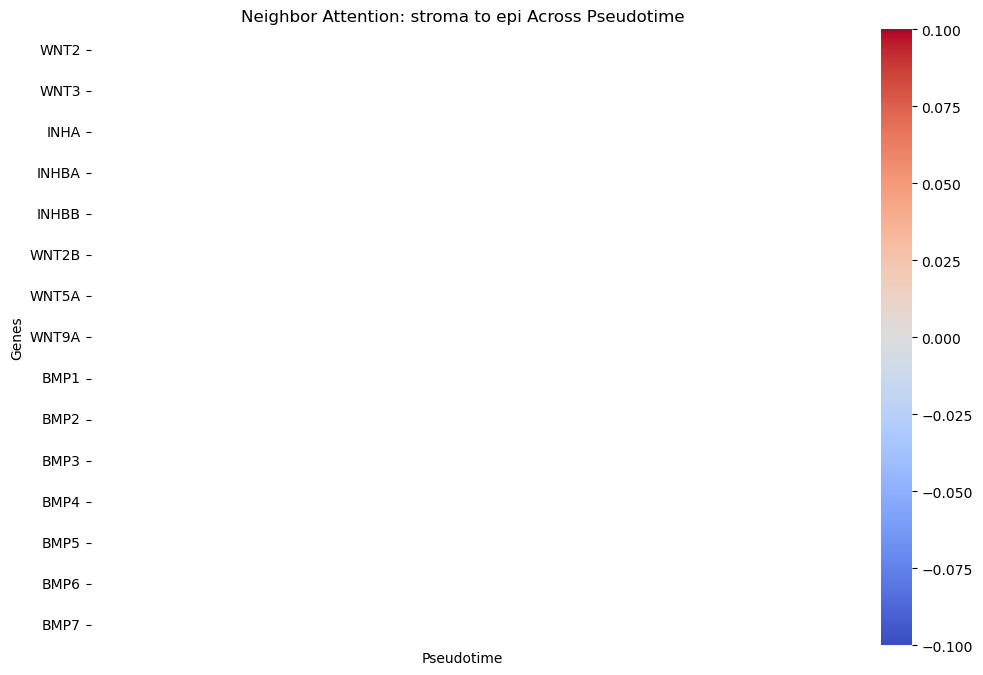

WNT2  WNT3  INHA  INHBA  INHBB  WNT2B  WNT5A  WNT9A  BMP1  BMP2  \
0.000000   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.000691   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.001035   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.001757   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.001965   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
...        ...   ...   ...    ...    ...    ...    ...    ...   ...   ...   
0.996920   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.997398   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.998076   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.999774   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
1.000000   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   

          BMP3  BMP4  BMP5  BMP6  BMP7  
0.000000   NaN   NaN   NaN   NaN   NaN  
0.000691   NaN   NaN   NaN   NaN   NaN  
0.001035   NaN   NaN   NaN   NaN   NaN  
0.001757   NaN   NaN   NaN   NaN   NaN  
0.001965   NaN   NaN   NaN   NaN   NaN  
...        ...   ...   ...   ...   ...  
0.996920   NaN   NaN   NaN   NaN   NaN  
0.997398   NaN   NaN   NaN   NaN   NaN  
0.998076   NaN   NaN   NaN   NaN   NaN  
0.999774   NaN   NaN   NaN   NaN   NaN  
1.000000   NaN   NaN   NaN   NaN   NaN  

[4251 rows x 15 columns]

In [91]:
importlib.reload(attention_analysis)


attention_analysis.analyze_stromal_to_epi_attention(
    embedding_adata,
    adata,
    pseudotime_key= "final_avg_pseudotime",
    cell_type_col= "subset",
    source_type= "stroma",
    target_type= "epi",
    gene_list= ["WNT2","WNT3","INHA","INHBA","INHBB","WNT2B","WNT5A","WNT9A","BMP1","BMP2","BMP3","BMP4","BMP5","BMP6","BMP7"],
    normalize= True,
)